##  2.3 Multi-Label News Article Classification

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score, hamming_loss, jaccard_score,precision_recall_fscore_support

In [2]:
train_df = pd.read_csv('news-article/train.csv')
test_df = pd.read_csv('news-article/test.csv')

In [3]:
print(train_df.shape)
print(test_df.shape)

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

(7769, 2)
(3019, 2)


In [4]:
#category : comma-separated string to list
train_df['category'] = train_df['category'].apply(lambda x: x.split(','))
test_df['category'] = test_df['category'].apply(lambda x: x.split(','))

In [5]:
print(train_df.head())
print(test_df.head())

                                            document        category
0  BAHIA COCOA REVIEW\n  Showers continued throug...         [cocoa]
1  COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...           [acq]
2  N.Z. TRADING BANK DEPOSIT GROWTH RISES SLIGHTL...  [money-supply]
3  NATIONAL AMUSEMENTS AGAIN UPS VIACOM &lt;VIA> ...           [acq]
4  ROGERS &lt;ROG> SEES 1ST QTR NET UP SIGNIFICAN...          [earn]
                                            document  \
0  ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...   
1  CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...   
2  JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...   
3  THAI TRADE DEFICIT WIDENS IN FIRST QUARTER\n  ...   
4  INDONESIA SEES CPO PRICE RISING SHARPLY\n  Ind...   

                                         category  
0                                         [trade]  
1                                         [grain]  
2                                [crude, nat-gas]  
3  [corn, grain, rice, rubber, sugar, tin

In [6]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

print(stop_words)  

{"mustn't", "she'd", "you've", 'having', 'ain', 'his', 'but', 'for', 'below', 'because', "didn't", 'weren', 'y', 'once', 'very', "it'd", 'both', 'has', 'most', 'of', 'what', 'a', 'mightn', 'wasn', "that'll", "he'd", 'their', "we're", 'so', 'themselves', "i'll", 'at', "i've", 'only', 'that', 'itself', 'we', 'she', 'should', "you're", 'them', 'down', 'above', 'such', 'now', "hasn't", 'this', 'her', "she'll", 'm', "couldn't", 'hasn', "wouldn't", "it'll", 'to', "we've", 'and', 'each', "we'd", 'not', 'theirs', 'your', "mightn't", 'll', 'over', 've', 'in', "you'd", 'there', "they're", "we'll", 'shouldn', 'yours', 'then', 'too', 'been', 'you', "wasn't", 'myself', 'than', 'those', "they'd", 'any', 'here', 'shan', 'no', 'the', 'can', 'had', 'more', 'ours', 'up', 'who', 'after', 'why', 'it', "shouldn't", "weren't", 'these', 'which', 'against', 'have', "you'll", 'while', 'won', 'i', 'did', "he's", 's', "isn't", 'between', 'nor', 'some', "don't", 'does', 'doing', 'didn', 'himself', 'herself', 'wil

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vpold\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Tokenization: Convert documents to lists of words
def tokenize(text):
    return [word for word in text.split() if word.lower() not in stop_words]

train_docs = [tokenize(doc) for doc in train_df['document']]
test_docs = [tokenize(doc) for doc in test_df['document']]

for i, doc in enumerate(train_docs[:5]):
    print(f"Document {i+1}:", doc)

Document 1: ['BAHIA', 'COCOA', 'REVIEW', 'Showers', 'continued', 'throughout', 'week', 'Bahia', 'cocoa', 'zone,', 'alleviating', 'drought', 'since', 'early', 'January', 'improving', 'prospects', 'coming', 'temporao,', 'although', 'normal', 'humidity', 'levels', 'restored,', 'Comissaria', 'Smith', 'said', 'weekly', 'review.', 'dry', 'period', 'means', 'temporao', 'late', 'year.', 'Arrivals', 'week', 'ended', 'February', '22', '155,221', 'bags', '60', 'kilos', 'making', 'cumulative', 'total', 'season', '5.93', 'mln', '5.81', 'stage', 'last', 'year.', 'seems', 'cocoa', 'delivered', 'earlier', 'consignment', 'included', 'arrivals', 'figures.', 'Comissaria', 'Smith', 'said', 'still', 'doubt', 'much', 'old', 'crop', 'cocoa', 'still', 'available', 'harvesting', 'practically', 'come', 'end.', 'total', 'Bahia', 'crop', 'estimates', 'around', '6.4', 'mln', 'bags', 'sales', 'standing', 'almost', '6.2', 'mln', 'hundred', 'thousand', 'bags', 'still', 'hands', 'farmers,', 'middlemen,', 'exporters', 

In [8]:
import math
word_counts = Counter(word for doc in train_docs for word in doc)
vocab = [word for word, _ in word_counts.most_common(5000)]
word_to_index = {word: i for i, word in enumerate(vocab)}

#tf-idf
df_counts = Counter()
for doc in train_docs:
    unique_words = set(doc)  
    for word in unique_words:
        if word in word_to_index:
            df_counts[word] += 1

# IDF
num_docs = len(train_docs)
idf = {word: math.log((num_docs / (df_counts[word] + 1)) + 1) for word in vocab}

#TF-IDF 
def compute_tfidf(doc, vocab, word_to_index, idf):
    tfidf_vector = np.zeros(len(vocab))
    word_freq = Counter(doc)
    total_words = sum(word_freq.values())

    for word, freq in word_freq.items():
        if word in word_to_index:  
            index = word_to_index[word]
            tf = freq / total_words  
            tfidf_vector[index] = tf * idf[word]  

    return tfidf_vector

#TF-IDF matrices
X_train_tfidf = np.array([compute_tfidf(doc, vocab, word_to_index, idf) for doc in train_docs])
X_test_tfidf = np.array([compute_tfidf(doc, vocab, word_to_index, idf) for doc in test_docs])

print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)

X_train_tfidf shape: (7769, 5000)
X_test_tfidf shape: (3019, 5000)


In [9]:
mlb = MultiLabelBinarizer()
Y_train = mlb.fit_transform(train_df['category'])
Y_test = mlb.transform(test_df['category'])

print("Class Labels:", mlb.classes_)

Class Labels: ['acq' 'alum' 'barley' 'bop' 'carcass' 'castor-oil' 'cocoa' 'coconut'
 'coconut-oil' 'coffee' 'copper' 'copra-cake' 'corn' 'cotton' 'cotton-oil'
 'cpi' 'cpu' 'crude' 'dfl' 'dlr' 'dmk' 'earn' 'fuel' 'gas' 'gnp' 'gold'
 'grain' 'groundnut' 'groundnut-oil' 'heat' 'hog' 'housing' 'income'
 'instal-debt' 'interest' 'ipi' 'iron-steel' 'jet' 'jobs' 'l-cattle'
 'lead' 'lei' 'lin-oil' 'livestock' 'lumber' 'meal-feed' 'money-fx'
 'money-supply' 'naphtha' 'nat-gas' 'nickel' 'nkr' 'nzdlr' 'oat' 'oilseed'
 'orange' 'palladium' 'palm-oil' 'palmkernel' 'pet-chem' 'platinum'
 'potato' 'propane' 'rand' 'rape-oil' 'rapeseed' 'reserves' 'retail'
 'rice' 'rubber' 'rye' 'ship' 'silver' 'sorghum' 'soy-meal' 'soy-oil'
 'soybean' 'strategic-metal' 'sugar' 'sun-meal' 'sun-oil' 'sunseed' 'tea'
 'tin' 'trade' 'veg-oil' 'wheat' 'wpi' 'yen' 'zinc']


In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train_tfidf, Y_train, test_size=0.2, random_state=42)

print("Train:", X_train.shape, Y_train.shape)
print("Validation:", X_val.shape, Y_val.shape)
print("Test:", X_test_tfidf.shape, Y_test.shape)

Train: (6215, 5000) (6215, 90)
Validation: (1554, 5000) (1554, 90)
Test: (3019, 5000) (3019, 90)


In [11]:
import numpy as np

# Activation Functions
class Activation:
    @staticmethod
    def sigmoid(x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
      
    
    @staticmethod
    def sigmoid_derivative(x):
        return x * (1 - x)

    @staticmethod
    def tanh(x):
        return np.tanh(x)
    
    @staticmethod
    def tanh_derivative(x):
        return 1 - np.tanh(x) ** 2

    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def relu_derivative(x):
        return np.where(x > 0, 1, 0)

# Optimizers
class Optimizer:
    @staticmethod
    def sgd(weights, gradients, learning_rate):
        return weights - learning_rate * gradients

    @staticmethod
    def batch_gd(weights, gradients, learning_rate, batch_size):
        return weights - (learning_rate / batch_size) * gradients

    @staticmethod
    def mini_batch_gd(weights, gradients, learning_rate, batch_size):
        return weights - (learning_rate / batch_size) * gradients

class MLP_multilabel:
    def __init__(self, input_size, hidden_layers, output_size, activation='sigmoid', optimizer='sgd', learning_rate=0.01):
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.activation = activation
        self.layers = [input_size] + hidden_layers + [output_size]

        self.weights = [np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(2 / self.layers[i]) for i in range(len(self.layers) - 1)]
        self.biases = [np.zeros((1, self.layers[i+1])) for i in range(len(self.layers) - 1)]
    
    def activate(self, x):
        if self.activation == 'sigmoid':
            return Activation.sigmoid(x)
        elif self.activation == 'tanh':
            return Activation.tanh(x)
        elif self.activation == 'relu':
            return Activation.relu(x)
    
    def activate_derivative(self, x):
        if self.activation == 'sigmoid':
            return Activation.sigmoid_derivative(x)
        elif self.activation == 'tanh':
            return Activation.tanh_derivative(x)
        elif self.activation == 'relu':
            return Activation.relu_derivative(x)
    
    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        
        for i in range(len(self.weights)):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            if np.any(np.isnan(z)) or np.any(np.isinf(z)):
              print("Warning: NaN or Inf detected in z values")
            self.z_values.append(z)
            a = self.activate(z) if i < len(self.weights) - 1 else Activation.sigmoid(z)  # Sigmoid at the output layer
            self.activations.append(a)
        
        return self.activations[-1]

    def binary_cross_entropy_loss(self, y_true, y_pred):
        return -np.mean(y_true * np.log(y_pred + 1e-9) + (1 - y_true) * np.log(1 - y_pred + 1e-9))

    def backpropagate(self, X, y_true):
        m = X.shape[0]
        d_weights = [np.zeros_like(w) for w in self.weights]
        d_biases = [np.zeros_like(b) for b in self.biases]

        #output error
        y_pred = self.activations[-1]
        error = y_pred - y_true  
        delta = error * (y_pred * (1 - y_pred)) 

        # Backpropagation
        for i in reversed(range(len(self.weights))):
            d_weights[i] = np.dot(self.activations[i].T, delta)
            d_biases[i] = np.sum(delta, axis=0, keepdims=True)
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.activate_derivative(self.z_values[i-1])

        return d_weights, d_biases

    def update_weights(self, d_weights, d_biases, batch_size=1):
        for i in range(len(self.weights)):
            if self.optimizer == 'sgd':
                self.weights[i] = Optimizer.sgd(self.weights[i], d_weights[i], self.learning_rate)
                self.biases[i] = Optimizer.sgd(self.biases[i], d_biases[i], self.learning_rate)
            elif self.optimizer == 'batch_gd':
                self.weights[i] = Optimizer.batch_gd(self.weights[i], d_weights[i], self.learning_rate, batch_size)
                self.biases[i] = Optimizer.batch_gd(self.biases[i], d_biases[i], self.learning_rate, batch_size)
            elif self.optimizer == 'mini_batch_gd':
                self.weights[i] = Optimizer.mini_batch_gd(self.weights[i], d_weights[i], self.learning_rate, batch_size)
                self.biases[i] = Optimizer.mini_batch_gd(self.biases[i], d_biases[i], self.learning_rate, batch_size)


    def train(self, X, y, epochs=100, batch_size=32):
        losses = []
        for epoch in range(epochs):
            loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                y_pred = self.forward(X_batch)
                loss += self.binary_cross_entropy_loss(y_batch, y_pred)
                
                d_weights, d_biases = self.backpropagate(X_batch, y_batch)
                self.update_weights(d_weights, d_biases, batch_size)

            loss /= (X.shape[0] / batch_size)
            losses.append(loss)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
        return losses

    def predict(self, X):
        probabilities = self.forward(X)
        return (probabilities >= 0.3).astype(int)  
    
    
    
    def evaluate(self, y_true, y_pred):
        y_pred_binary = (y_pred >= 0.3).astype(int)
        hamming = hamming_loss(y_true, y_pred_binary)

        return hamming
    
    def predict_raw(self, X):
        probabilities = self.forward(X)  
        print("Raw Probabilities:\n", probabilities[:5])  
        new_prob = (probabilities >= 0.3).astype(int)
        print("new Probabilities:\n", new_prob[:2]) 
        return probabilities
    
    def evaluate_f2(self,y_true,y_pred):
        y_pred_binary = (y_pred >= 0.3).astype(int)  
    
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_binary, average='macro')  
        
        return precision, recall, f1


In [12]:
mlp = MLP_multilabel(input_size=5000, hidden_layers=[128, 64], output_size=90, activation='relu', learning_rate=0.001)
mlp.train(X_train, Y_train, epochs=30, batch_size=32)
predictions = mlp.predict(X_test_tfidf)
hamming = mlp.evaluate(Y_test, predictions) 


Epoch 0, Loss: 0.1781
Epoch 10, Loss: 0.0503
Epoch 20, Loss: 0.0463


In [120]:
accuracy= accuracy_score(Y_test, predictions)
print(f"Accuracy: {accuracy}, Hamming Loss: {hamming}")

Accuracy: 0.543888704869162, Hamming Loss: 0.009307717787346804



Training with {'architecture': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 32, 'optimizer': 'sgd'}

Epoch 0, Loss: 0.1810
Epoch 10, Loss: 0.0499
Epoch 20, Loss: 0.0459

Training with {'architecture': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 32, 'optimizer': 'batch'}

Epoch 0, Loss: 0.2002
Epoch 10, Loss: 0.0505
Epoch 20, Loss: 0.0465

Training with {'architecture': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 32, 'optimizer': 'mini-batch'}

Epoch 0, Loss: 0.1814
Epoch 10, Loss: 0.0503
Epoch 20, Loss: 0.0462

Training with {'architecture': [256, 128], 'activation': 'relu', 'learning_rate': 0.0005, 'epochs': 40, 'batch_size': 32, 'optimizer': 'sgd'}

Epoch 0, Loss: 0.2756
Epoch 10, Loss: 0.0519
Epoch 20, Loss: 0.0503
Epoch 30, Loss: 0.0486

Training with {'architecture': [256, 128], 'activation': 'relu', 'learning_rate': 0.0005, 'epochs': 40, 'batch_size': 32, 'op

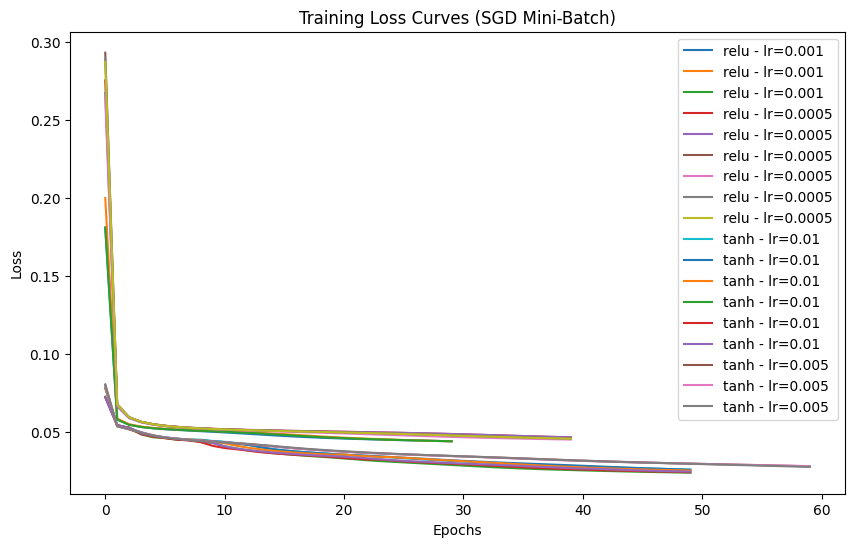


Ordered Results:
{'architecture': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 50, 'batch_size': 64, 'optimizer': 'sgd'}: Accuracy=0.6790, Hamming Loss=0.0057
{'architecture': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 50, 'batch_size': 64, 'optimizer': 'mini-batch'}: Accuracy=0.6741, Hamming Loss=0.0057
{'architecture': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 50, 'batch_size': 64, 'optimizer': 'mini-batch'}: Accuracy=0.6727, Hamming Loss=0.0058
{'architecture': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 50, 'batch_size': 64, 'optimizer': 'batch'}: Accuracy=0.6727, Hamming Loss=0.0058
{'architecture': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 50, 'batch_size': 64, 'optimizer': 'batch'}: Accuracy=0.6668, Hamming Loss=0.0059
{'architecture': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 50, 'batch_size': 64, 'optimizer': 'sgd'}: Accuracy=0.6641, Ham

In [13]:
import matplotlib.pyplot as plt
configs = [

    {"architecture": [128, 64], "activation": "relu", "learning_rate": 0.001, "epochs": 30, "batch_size": 32, "optimizer": "sgd"},
    {"architecture": [128, 64], "activation": "relu", "learning_rate": 0.001, "epochs": 30, "batch_size": 32, "optimizer": "batch"},
    {"architecture": [128, 64], "activation": "relu", "learning_rate": 0.001, "epochs": 30, "batch_size": 32, "optimizer": "mini-batch"},
    
    {"architecture": [256, 128], "activation": "relu", "learning_rate": 0.0005, "epochs": 40, "batch_size": 32, "optimizer": "sgd"},
    {"architecture": [256, 128], "activation": "relu", "learning_rate": 0.0005, "epochs": 40, "batch_size": 32, "optimizer": "batch"},
    {"architecture": [256, 128], "activation": "relu", "learning_rate": 0.0005, "epochs": 40, "batch_size": 32, "optimizer": "mini-batch"},
    
    {"architecture": [512, 256], "activation": "relu", "learning_rate": 0.0005, "epochs": 40, "batch_size": 32, "optimizer": "sgd"},
    {"architecture": [512, 256], "activation": "relu", "learning_rate": 0.0005, "epochs": 40, "batch_size": 32, "optimizer": "batch"},
    {"architecture": [512, 256], "activation": "relu", "learning_rate": 0.0005, "epochs": 40, "batch_size": 32, "optimizer": "mini-batch"},
 
    {"architecture": [128, 64], "activation": "tanh", "learning_rate": 0.01, "epochs": 50, "batch_size": 64, "optimizer": "sgd"},
    {"architecture": [128, 64], "activation": "tanh", "learning_rate": 0.01, "epochs": 50, "batch_size": 64, "optimizer": "batch"},
    {"architecture": [128, 64], "activation": "tanh", "learning_rate": 0.01, "epochs": 50, "batch_size": 64, "optimizer": "mini-batch"},
    
    {"architecture": [256, 128], "activation": "tanh", "learning_rate": 0.01, "epochs": 50, "batch_size": 64, "optimizer": "sgd"},
    {"architecture": [256, 128], "activation": "tanh", "learning_rate": 0.01, "epochs": 50, "batch_size": 64, "optimizer": "batch"},
    {"architecture": [256, 128], "activation": "tanh", "learning_rate": 0.01, "epochs": 50, "batch_size": 64, "optimizer": "mini-batch"},
    
    {"architecture": [512, 256], "activation": "tanh", "learning_rate": 0.005, "epochs": 60, "batch_size": 64, "optimizer": "sgd"},
    {"architecture": [512, 256], "activation": "tanh", "learning_rate": 0.005, "epochs": 60, "batch_size": 64, "optimizer": "batch"},
    {"architecture": [512, 256], "activation": "tanh", "learning_rate": 0.005, "epochs": 60, "batch_size": 64, "optimizer": "mini-batch"}
]

results = {}

plt.figure(figsize=(10, 6))

for config in configs:
    print(f"\nTraining with {config}\n")

    mlp = MLP_multilabel(
        input_size=X_train.shape[1],
        hidden_layers=config["architecture"],
        output_size=Y_train.shape[1],
        activation=config["activation"],
        learning_rate=config["learning_rate"],
        optimizer="sgd" 
    )

    losses = mlp.train(X_train, Y_train, epochs=config["epochs"], batch_size=config["batch_size"])
    
    predictions = mlp.predict(X_test_tfidf)
    accuracy = accuracy_score(Y_test, predictions)
    hamming = hamming_loss(Y_test, predictions)

    results[str(config)] = {"accuracy": accuracy, "hamming_loss": hamming}

    plt.plot(range(config["epochs"]), losses, label=f"{config['activation']} - lr={config['learning_rate']}")

#loss curves
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Curves (SGD Mini-Batch)")
plt.show()

sorted_results = sorted(results.items(), key=lambda x: x[1]["accuracy"], reverse=True)

print("\nOrdered Results:")
for config, metrics in sorted_results:
    print(f"{config}: Accuracy={metrics['accuracy']:.4f}, Hamming Loss={metrics['hamming_loss']:.4f}")

# Best Configuration
print("\nBest Configuration:")
print(sorted_results[0])